# Problem Set 3 - Flowers 102 Dataset

- Load the Flowers 102 dataset and plot some of the images with their class labels.
- Load a pretrained Alexnet model and show its outputs on some of the loaded images.
- Finetune the network to classify the Flowers 102 dataset. Try to reach at least 75% accuracy.
- Create a markdown (.md) report and add it to your GitHub

In [2]:
import requests
import zipfile
import os
import torch
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim

## Load Data and Plot Images w/ Labels

flower_data.zip already exists
Oxford-102_Flower_dataset_labels.txt already exists
Dataset extracted
Images tensor shape: torch.Size([6552, 3, 224, 224])
Labels tensor shape: torch.Size([6552])
Training batch image tensor size: torch.Size([4, 3, 224, 224])
Training batch label size: torch.Size([4])


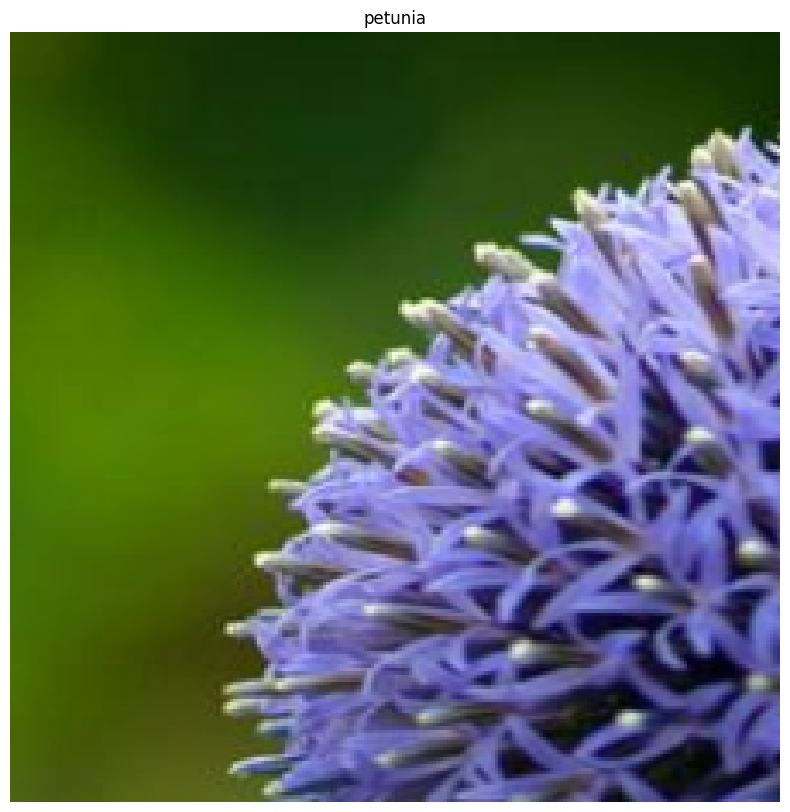

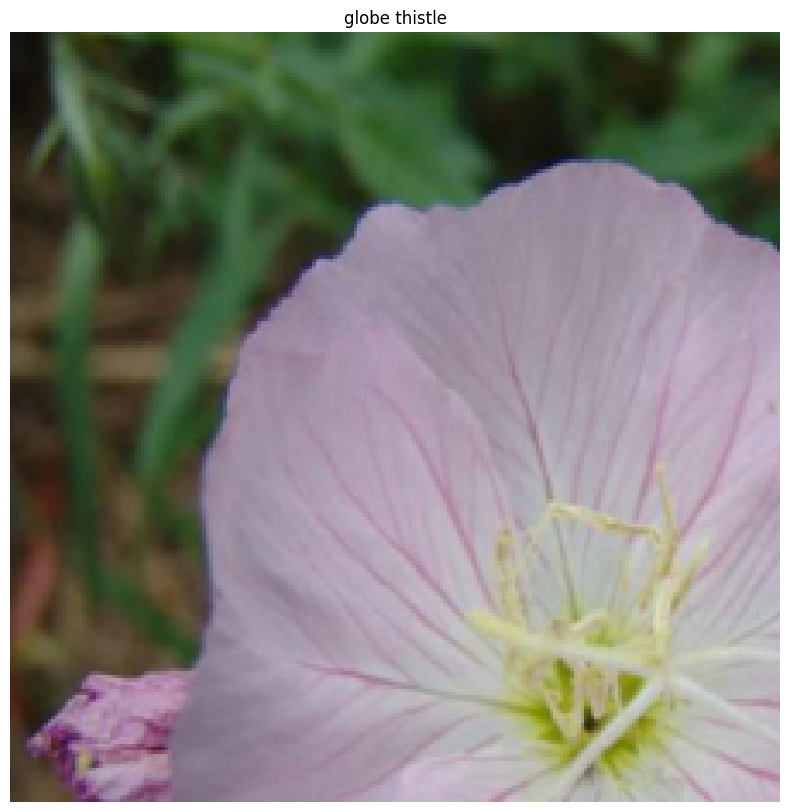

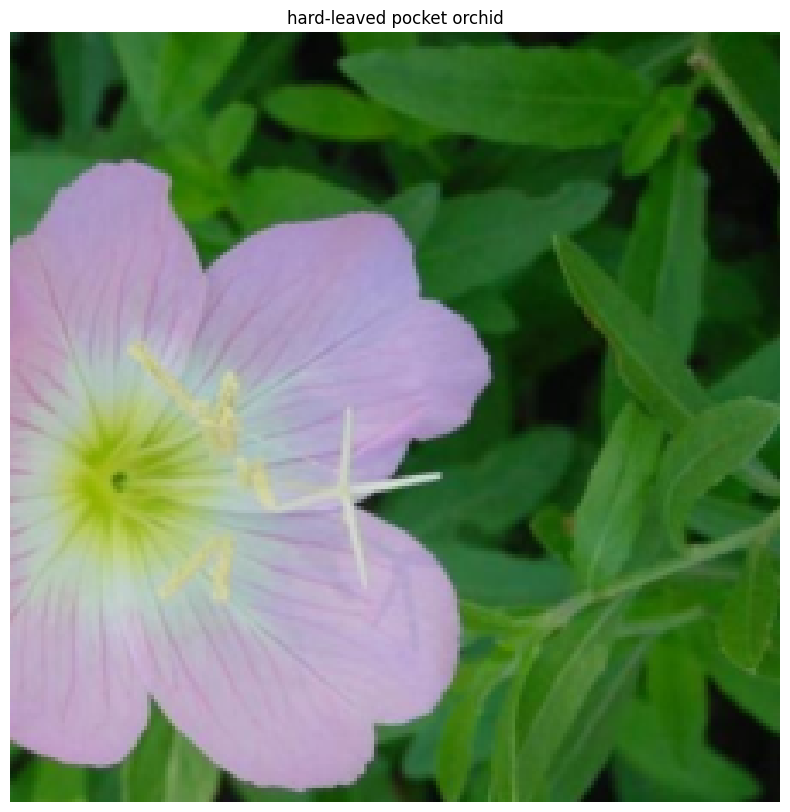

In [3]:
# URLs for the zip data
data_urls = {
    'train': 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip',
    'label': 'https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt'
}

# Define the download function
def download_data(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)

# Download the data
for key, url in data_urls.items():
    file_name = url.split('/')[-1]
    if not os.path.exists(file_name):
        download_data(url, file_name)
        print(f'Downloaded {file_name}')
    else:
        print(f'{file_name} already exists')

# Check if the dataset zip file is downloaded and then extract it
if os.path.exists('flower_data.zip'):
    with zipfile.ZipFile('flower_data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print('Dataset extracted')
else:
    print('Dataset zip file not found')
    
# Define the directory for the dataset
data_dir = '../problem-set-3/flower_data/'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

#transform image for use in model
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transform)
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt', header=None)[0].str.replace("'", "").str.strip()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

flower_names = dataset_labels.tolist()

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=preprocess)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)

images, labels = next(iter(dataloader))
print(f"Images tensor shape: {images.shape}")
print(f"Labels tensor shape: {labels.shape}")

train_images, train_labels = next(iter(trainloader))
print(f"Training batch image tensor size: {train_images.size()}")
print(f"Training batch label size: {train_labels.size()}")

def plot(x, title=None):
    # Move tensor to CPU and convert to numpy
    x_np = x.cpu().numpy()

    # If tensor is in (C, H, W) format, transpose to (H, W, C)
    if x_np.shape[0] == 3 or x_np.shape[0] == 1:
        x_np = x_np.transpose(1, 2, 0)

    # Apply the inverse normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x_np = x_np * std + mean
    x_np = np.clip(x_np, 0, 1)  # Ensure values are within [0, 1] range

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.imshow(x_np)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

for i in [50,9,1]:
    plot(images[i],flower_names[i])

## Load Pretrained Alexnet Model & Plot Images w/ Predictions

/Users/cam/IdeaProjects/Math-for-Data-Science/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cam/IdeaProjects/Math-for-Data-Science/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


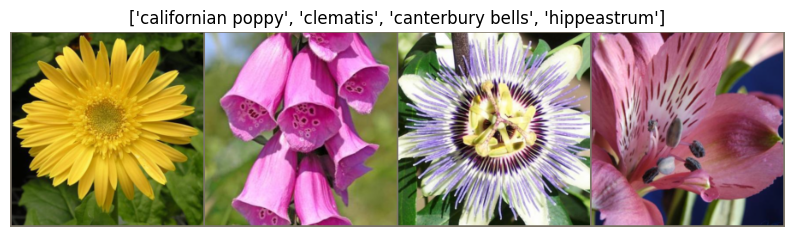

In [4]:
#define alexnet model
alexnet = models.alexnet(pretrained=True)
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

num_classes = len(train_data.classes)
alexnet.classifier[6] = torch.nn.Linear(alexnet.classifier[6].in_features, num_classes)

# Fetch a batch of data
dataiter = iter(trainloader)
images, labels = next(dataiter)

outputs = alexnet(images)
_, predicted = torch.max(outputs, 1)
predicted_flower_names = [flower_names[p.item()] for p in predicted]

plot(torchvision.utils.make_grid(images), title=[name for name in predicted_flower_names])

## Finetuning & Plot True/Predicted Values

In [5]:
# Adjust the final layer of AlexNet
num_classes = len(dataset.classes)
alexnet.classifier[6] = torch.nn.Linear(alexnet.classifier[6].in_features, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

num_epochs = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move data to the device
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

print('Finished Training')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Move the images to the same device as the model
images = images.to(device)
labels = labels.to(device)

# Predict using the trained model
outputs = alexnet(images)
_, predicted = torch.max(outputs, 1)
predicted_flower_names = [flower_names[p.item()] for p in predicted]
true_flower_names = [flower_names[label.item()] for label in labels]

# If you want to display the images using imshow, move them back to CPU
images = images.cpu()


Epoch 1, Loss: 0.0029709740872784847
Finished Training


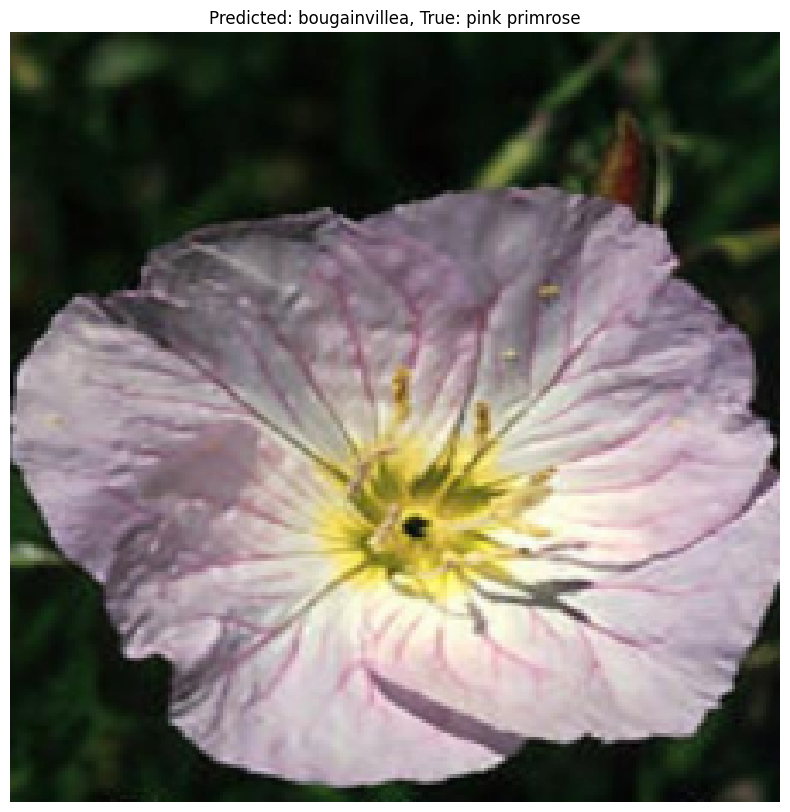

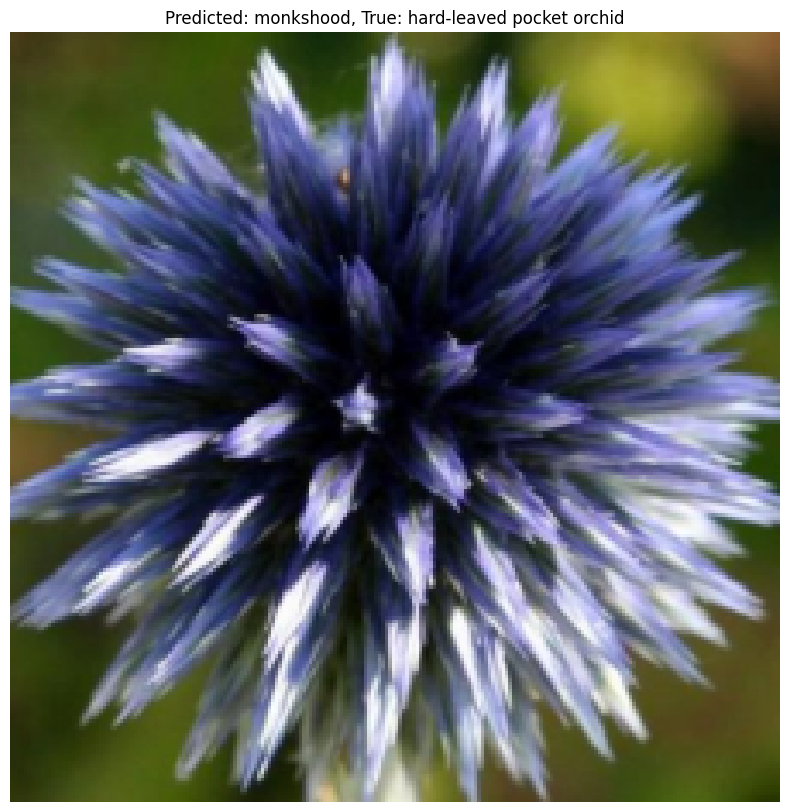

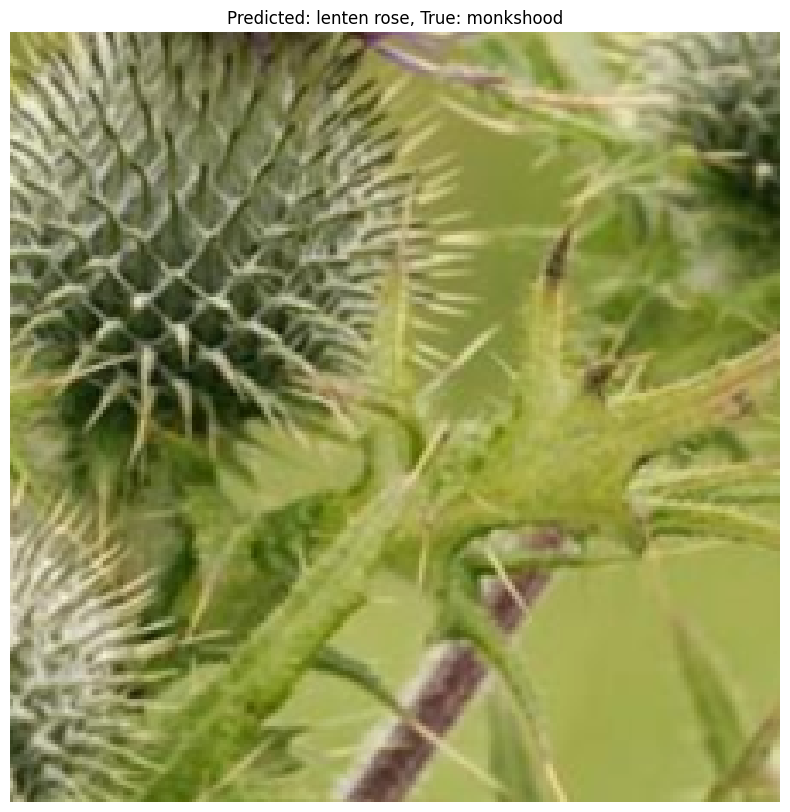

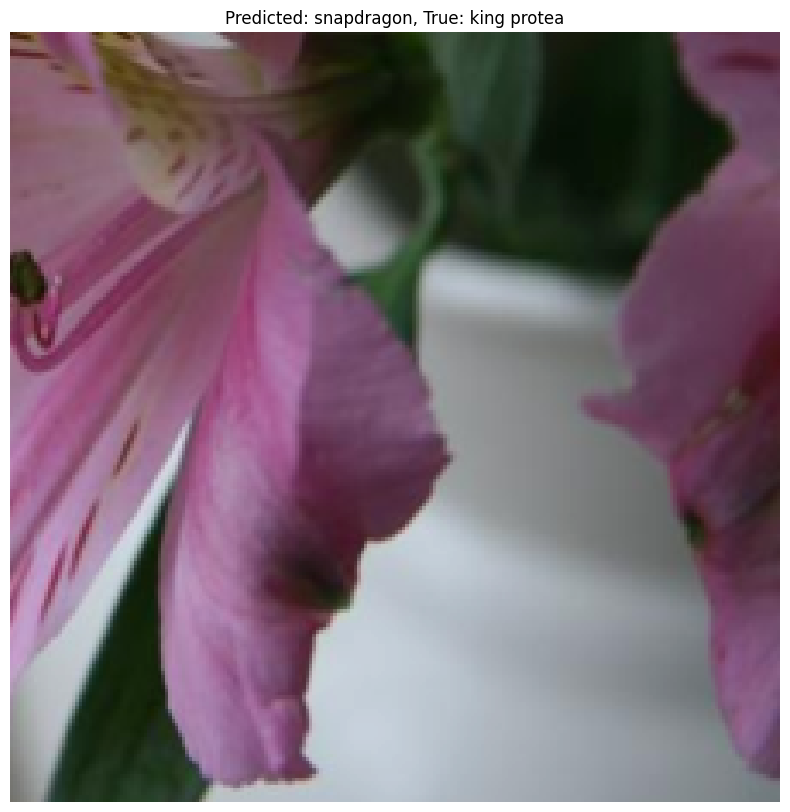

Predicted: ['thorn apple', 'barbeton daisy', 'thorn apple', 'osteospermum', 'hippeastrum', 'columbine', 'azalea', 'thorn apple', 'giant white arum lily', 'canna lily', 'tree mallow', 'osteospermum', 'globe-flower', 'thorn apple', 'hibiscus', 'bee balm', 'thorn apple', 'desert-rose', 'tree mallow', 'azalea', 'azalea', 'azalea', 'gazania', 'alpine sea holly', 'petunia', 'english marigold', 'desert-rose', 'barbeton daisy', 'oxeye daisy', 'daffodil', 'windflower', 'prince of wales feathers', 'columbine', 'ruby-lipped cattleya', 'osteospermum', 'alpine sea holly', 'canna lily', 'ruby-lipped cattleya', 'watercress', 'purple coneflower', 'columbine', 'columbine', 'osteospermum', 'columbine', 'desert-rose', 'osteospermum', 'great masterwort', 'alpine sea holly', 'bishop of llandaff', 'monkshood', 'windflower', 'hibiscus', 'canna lily', 'silverbush', 'columbine', 'columbine', 'osteospermum', 'alpine sea holly', 'columbine', 'frangipani', 'columbine', 'black-eyed susan', 'osteospermum', 'moon or

In [6]:
# Define specific indices of images you want to check
specific_indices = [10, 60, 400, 600]  # Example indices

# Initialize lists to store selected images and labels
selected_images = []
selected_labels = []
selected_predictions = []

# Iterate over the specific indices and fetch images and labels
for idx in specific_indices:
    image, label = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    output = alexnet(image)
    _, predicted = torch.max(output, 1)

    selected_images.append(image.cpu().squeeze(0))  # Remove batch dimension and move to CPU
    selected_labels.append(label)
    selected_predictions.append(predicted.cpu().item())

# Convert the lists of images and labels to a batch tensor
images_batch = torch.stack(selected_images)
labels_batch = torch.tensor(selected_labels)
predictions_batch = torch.tensor(selected_predictions)

# Convert predicted and true labels to flower names
sample_predicted_flower_names = [flower_names[pred] for pred in predictions_batch]
sample_true_flower_names = [flower_names[label.item()] for label in labels_batch]

# Plot the images
for i in range(len(selected_images)):
    plot(selected_images[i], title=f"Predicted: {sample_predicted_flower_names[i]}, True: {sample_true_flower_names[i]}")

print(f"Predicted: {predicted_flower_names}")
print(f"True: {true_flower_names}")